In [1]:
import os
import re
import torch
import warnings
import pandas as pd
import numpy as np

from torch import nn
from termcolor import colored
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from collections import Counter, defaultdict
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ImageDataset import ImageDataset, get_img_for_train_and_val, collate_fn
from imgPrepare import img_prepare, create_img_transform
%load_ext autoreload
%autoreload 2

In [3]:
img_transform = create_img_transform((640, 640))
train, test = get_img_for_train_and_val("data")
# train, test = get_img_for_train_and_val("data", img_count = 24)

In [4]:
dataset_train = ImageDataset(train, img_prepare, img_transform)
dataset_test = ImageDataset(test, img_prepare, img_transform)

  0%|          | 0/1326 [00:00<?, ?it/s]

/home/nikitinmaxim081102/anaconda3/envs/univer/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/531 [00:00<?, ?it/s]

In [5]:
def collate_fn(batch):
    img_batch = torch.stack([elem[0] for elem in batch])
    mask_batch = torch.stack([elem[1] for elem in batch])
    return img_batch, mask_batch

In [6]:
batch_size = 8

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [7]:
class segFormer(nn.Module):
    def __init__(self):
        super(segFormer, self).__init__()
        self.segFormer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
        for param in self.segFormer.segformer.parameters():
            param.requires_grad = False
        self.segFormer.decode_head.classifier = nn.Conv2d(768, 2, kernel_size=(1, 1), stride=(1, 1))
    
    def forward(self, x, mask=None):
        x = x.float()
        if mask is None:
            output = self.segFormer(x)
        else:
            output = self.segFormer(x, labels=mask.long())
        return output

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    optimized_params = []
    for param in model.parameters():
        if param.requires_grad:
            optimized_params.append(param)
    optimizer = torch.optim.Adam(optimized_params, lr, [beta1, beta2])
    return model, optimizer

In [9]:
a = torch.Tensor([[1, 2], [3,4]])
a.flatten()

tensor([1., 2., 3., 4.])

In [10]:
def calculate_diceCoef(pred, real):
    axis = (1, 2)
    pred = 1 - pred.cpu().repeat_interleave(4, dim=2).repeat_interleave(4, dim=1).numpy()
    real = 1 - real.cpu().numpy()
    intersection = (2 * pred * real).sum(axis=axis)
    unification = pred.sum(axis=axis) + real.sum(axis=axis)
    return (intersection/ unification).mean()


def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for imgs_batch, mask_batch in tqdm(loader):
        optimizer.zero_grad()
        imgs_batch = imgs_batch.to(device)
        mask_batch = mask_batch.to(device)
        pred = model(imgs_batch, mask_batch).logits
        log_pred = nn.functional \
            .log_softmax(pred.permute(0, 2, 3, 1), dim=3) \
            .repeat_interleave(4, dim=2) \
            .repeat_interleave(4, dim=1) \
#         print(log_pred.flatten(start_dim=1, end_dim=2).shape, mask_batch.flatten(start_dim=1, end_dim=2).shape)
        loss = criterion(
            log_pred.flatten(start_dim=0, end_dim=2), 
            mask_batch.flatten(start_dim=0, end_dim=2).long()
        )
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for imgs_batch, mask_batch in tqdm(loader):
            imgs_batch = imgs_batch.to(device)
            mask_batch = mask_batch.to(device)
            pred = model(imgs_batch, mask_batch).logits
            log_pred = nn.functional \
                .log_softmax(pred.permute(0, 2, 3, 1), dim=3) \
                .repeat_interleave(4, dim=2) \
                .repeat_interleave(4, dim=1)
            loss = criterion(
                log_pred.flatten(start_dim=0, end_dim=2), 
                mask_batch.flatten(start_dim=0, end_dim=2).long()
            )

            losses_val.append(loss.item())
            
            if metric_names is not None:
                if 'diceCoefficient' in metric_names:
                    preds = torch.max(pred.permute(0, 2, 3, 1), dim=-1).indices
                    metrics['diceCoefficient'].append(
                            calculate_diceCoef(preds, mask_batch)
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    return np.mean(losses_val), metrics if metric_names else None

In [49]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
    save_only_best=True,
):
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    
    if os.path.exists(os.path.join(chkp_folder, model_name)):
        model_name = model_name + "_v2"
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    os.makedirs(os.path.join(chkp_folder, model_name))
    
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)
            
            if ((not save_only_best) or (loss < best_val_loss)):
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name, f'{model_name}#{epoch}.pt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot id", 1)]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append(el[0])
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys in plot_ids.items():
                    for key in keys:
                        plt.subplot(1, ww + ww_metrics, ww + plot_id)
                        plt.title(f'additional metrics #{plot_id}')
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                        plt.legend()
                        plt.grid()
            
            plt.show()
            
            number = np.random.randint(0, len(dataset_test))
            img, mask = dataset_test[number]
            outputs = model(img[None].float().cuda())
            logits = outputs.logits.cpu() 
            logits = logits.permute(0, 2, 3, 1)
            res = torch.max(logits, dim=-1).indices
            res_for_plt = res.repeat_interleave(4, dim=2).repeat_interleave(4, dim=1).repeat(3, 1, 1).numpy().transpose((1, 2, 0)).astype('float32')
            fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize=(15, 15))
            axs[0].imshow(res_for_plt)
            axs[1].imshow(mask.numpy())
            axs[2].imshow(img.numpy().transpose(1, 2, 0))

        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

In [50]:
np.random.randint(0, 3)

1

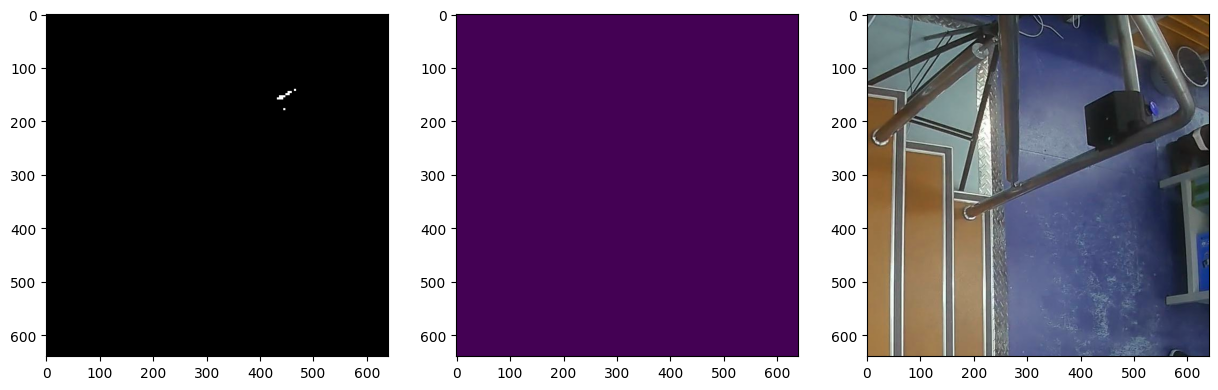

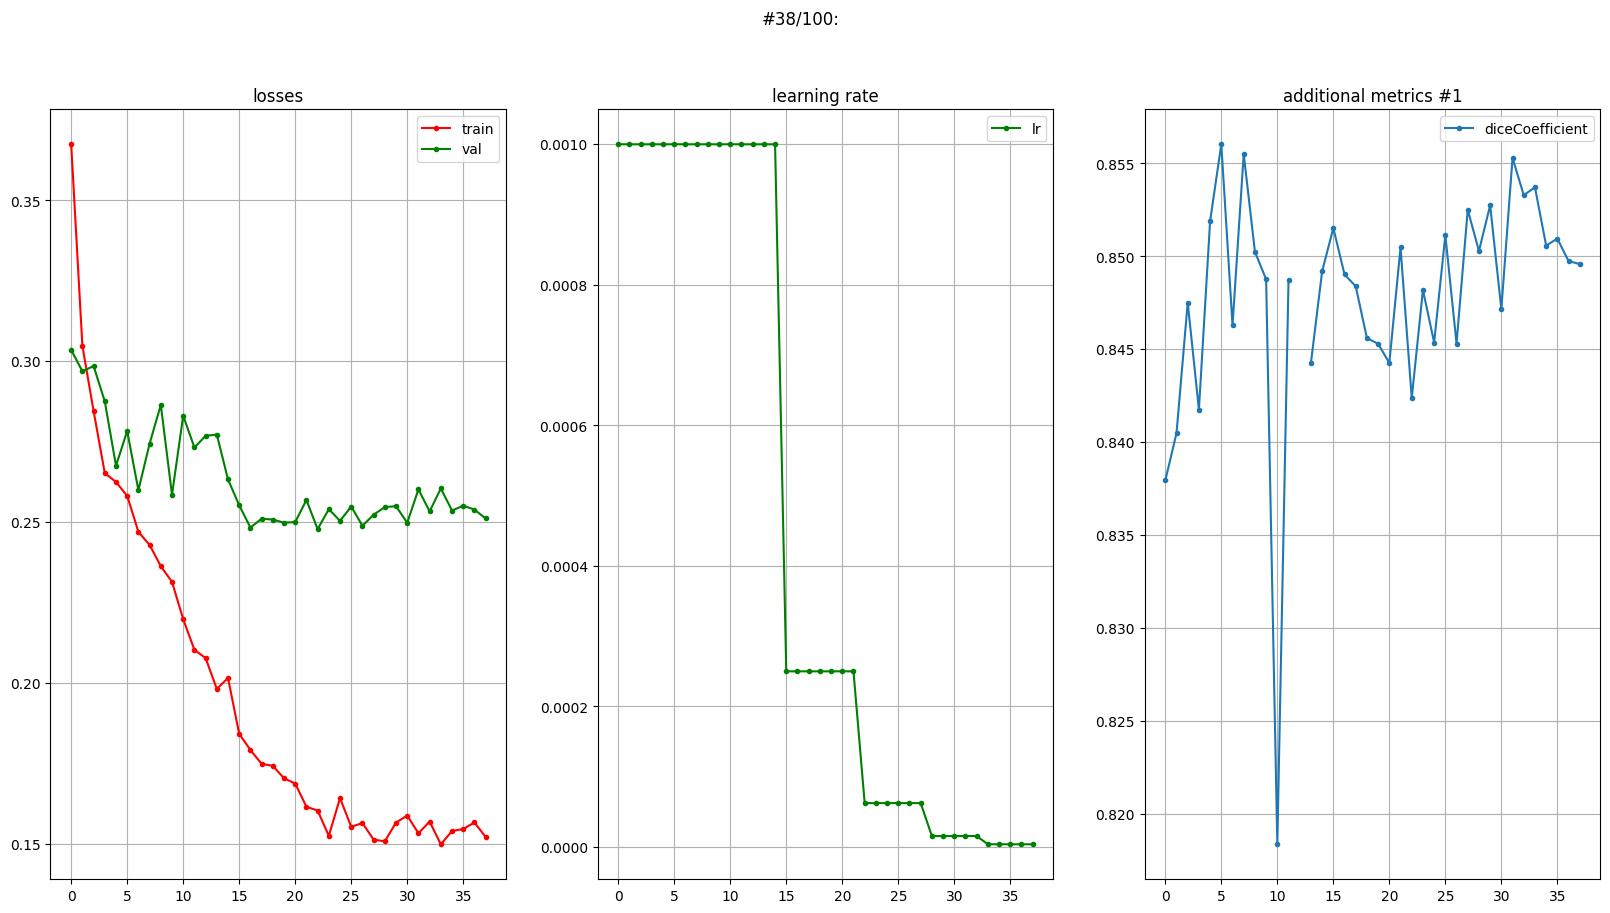

Learning process ended with early stop after epoch 38
CPU times: user 1h 26min 7s, sys: 9min 26s, total: 1h 35min 33s
Wall time: 1h 24min 48s


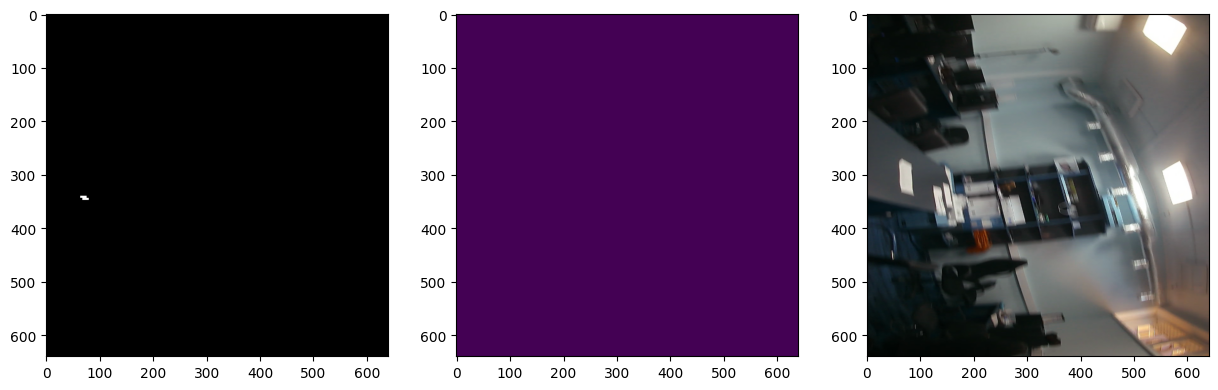

In [51]:
%%time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model, optimizer = create_model_and_optimizer(
    model_class = segFormer,
    model_params = {},
    lr = 1e-3,
    device = device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

criterion = nn.NLLLoss(weight=torch.Tensor([1.4, 1.65]).to(device))

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "diceCoefficient": {"plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "segFormerLearnDecode"
)

In [141]:
torch.save(
                    {
                        'epoch': 38,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join("./chkp", "segFormerLearnDecode_v2", f'segFormerLearnDecode_v2#{38}.pt'),
                )

In [52]:
import cv2

In [238]:
def show_examples(count):
    for i in range(count):
        number = np.random.randint(0, len(dataset_test))
        img, mask = dataset_test[number]
        outputs = model(img[None].float().cuda())
        logits = outputs.logits.cpu() 
        logits = logits.permute(0, 2, 3, 1)
        res = torch.max(logits, dim=-1).indices
        res_for_plt = res.repeat_interleave(4, dim=2).repeat_interleave(4, dim=1).repeat(3, 1, 1).numpy().transpose((1, 2, 0)).astype('float32')
        fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize=(15, 15))
        axs[0].imshow(res_for_plt)
        axs[1].imshow(mask.numpy())
        axs[2].imshow(img.numpy().transpose(1, 2, 0))


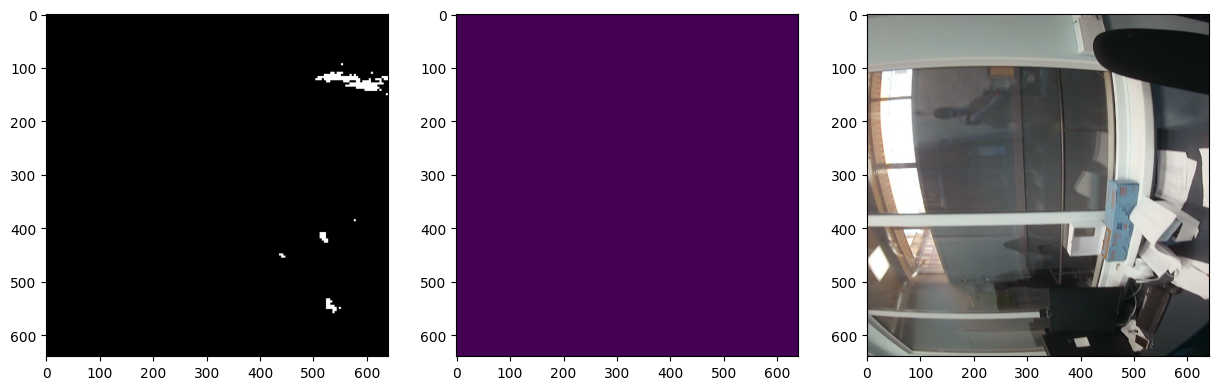

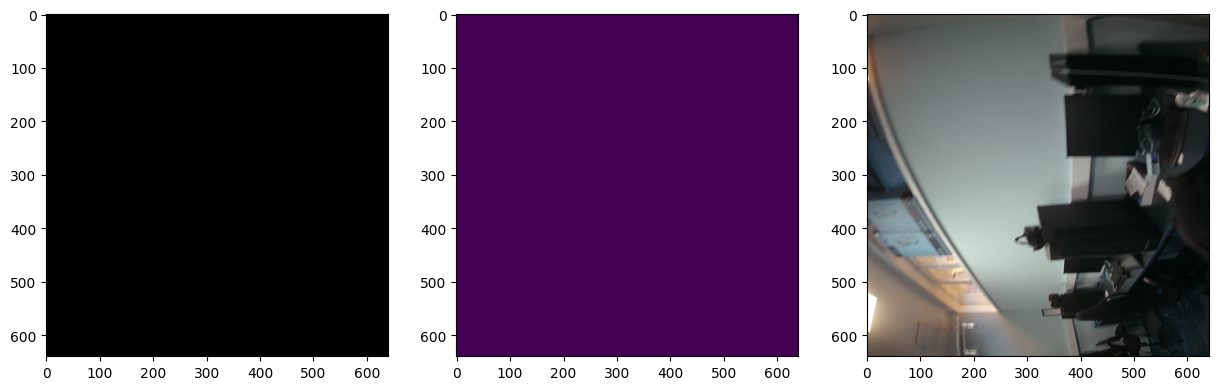

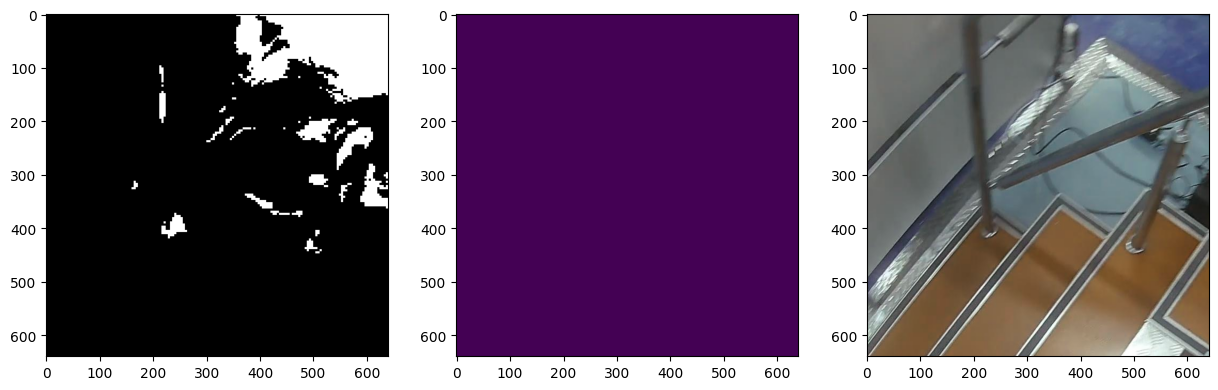

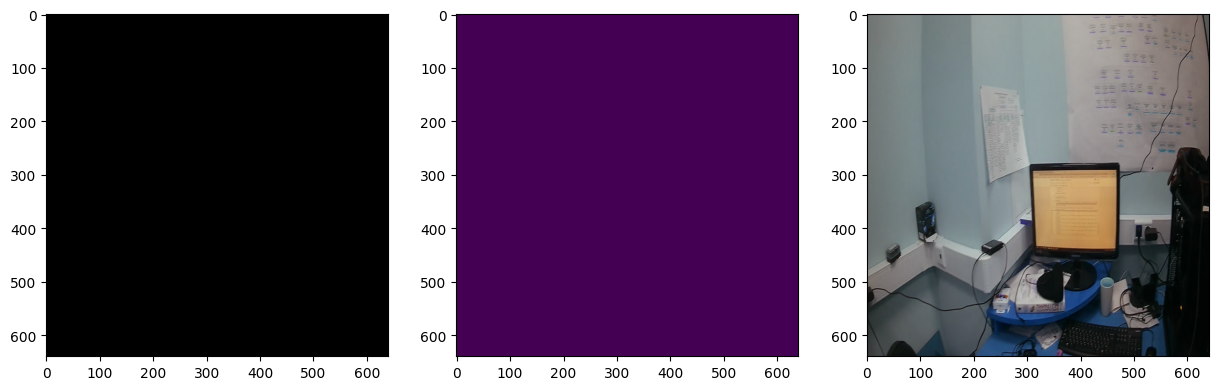

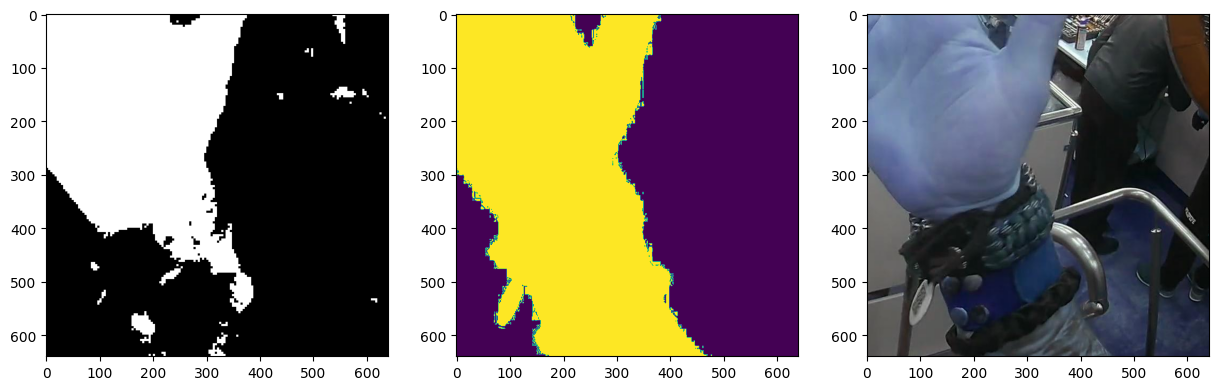

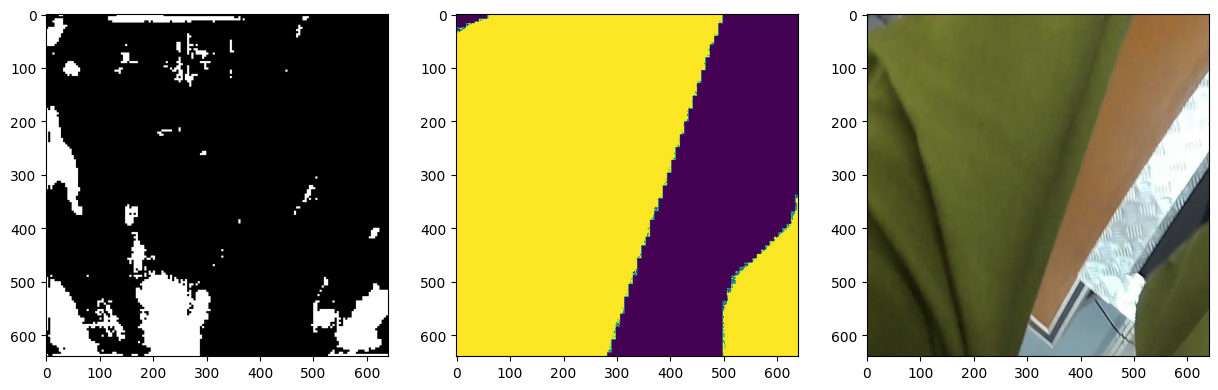

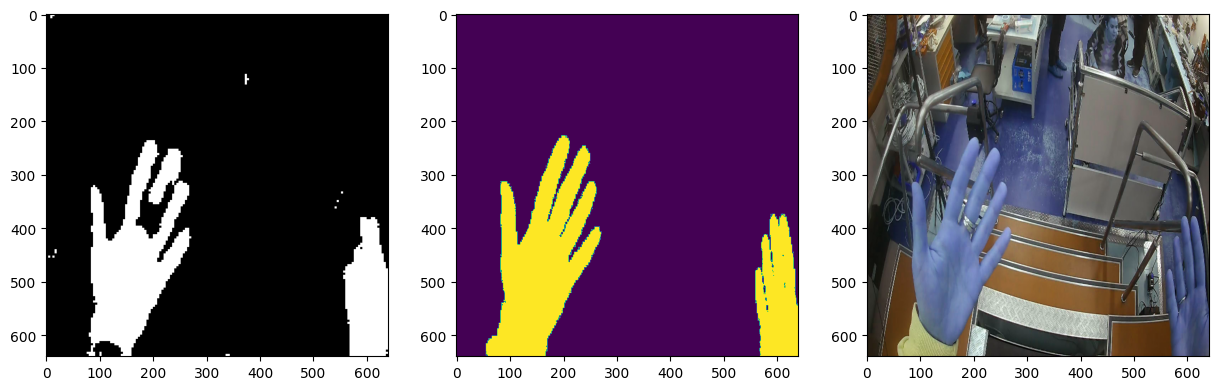

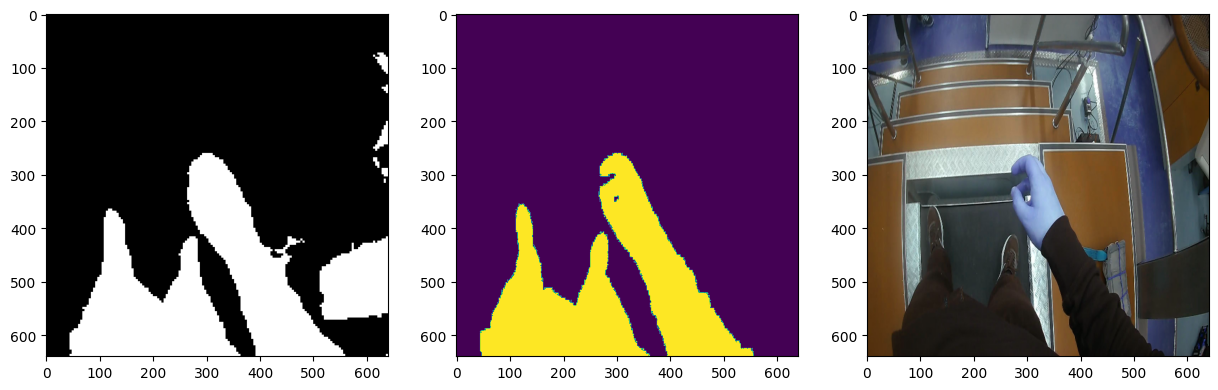

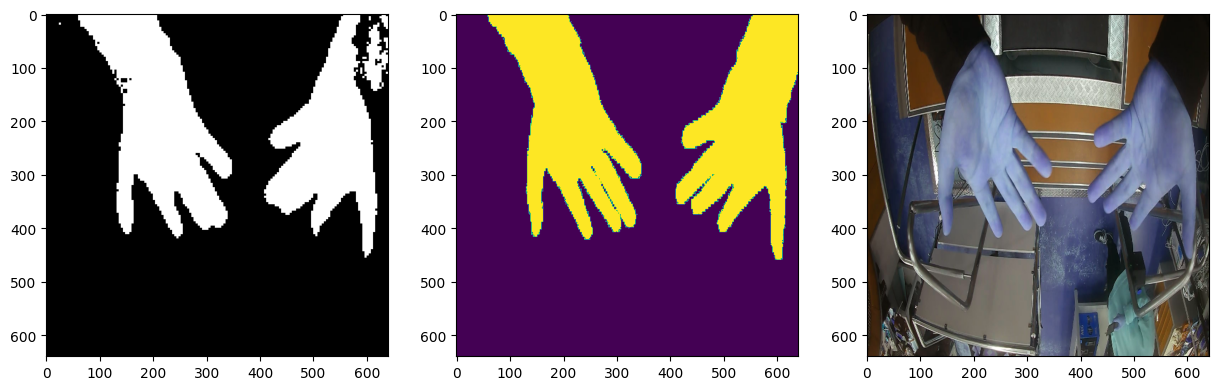

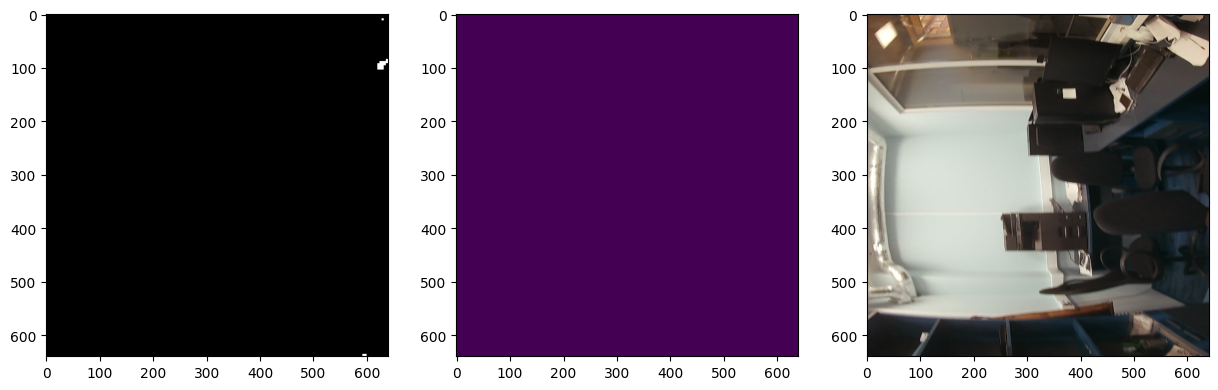

In [242]:
show_examples(10)